## Pruning
<div class='alert alert-success'>
Ce petit notebook permet d'évaluer AbstractWeight sur un petit réseau. 
Pour cela, on créé AbstractNN, un petit réseau composé de 2 couches de convolution suivies de ReLU, d'un maxpool2D,  puis de deux couches FC suivies également de ReLU. 
Pour l'entrainement uniquement, un softmax est appliqué en sortie de réseau
</div>

Dans la classe AbstractNN, la méthode forward de nn.Linear est surchargée de façon standard.
C'est à dire que si l'on instancie model=AbstractNN(), model(x) applique forward à x comme dans n'importe quel réseau. 

AbstractNN possède une méthode abstract_forward() qui fait appelle à AbstractLinear et AbstractReLU, AbstractMaxpool et AbstractWeights.

Le réseau est préalablement entraîné. On va tenter d'analyser le comportement du réseau autour des poids que l'on souhaite retirer. Pour cela, on recherche premièrement les candidats à l'élagage (méthode heuristique, poids les plus faibles en valeur absolu). On en selectionne une quantité n, puis on analyse le comportement du réseau autour de ces poids: 

$$\forall p\in [1,m], y_p = \sum_{k=1}^n w_{pk} x_k +\alpha_{pk}x_k  \delta_{pk} $$

On utilise pour cela la classe AbstractWeight, qui convertit une couche FC dans un réseau en domaine abstrait. Cette classe prend en argument l'index des poids à bruiter, les valeurs du bruits. 
Dans le cadre de l'élagage, on souhaite que l'expression affine inclue la valeur pour laquelle le poids est nul. On choisit donc un alpha de bruit valant le poids en valeur absolu plus un coeficient de marge (10%). 
On est donc certain que l'expression affine en sortie du réseau inclue l'image de la matrice élaguée. 

Enfin on observe la relevance sur la matrice de poids. Cette relevance est normalisée par la valeur de alpha. 
Les indices ayant une forte relevance ont donc contribué à la dispersion du domaine, ils affectent en premier lieu la dominance.

On étudiera par la suite une méthode pour retirer de la liste des candidats à l'élagage les poids contribuants le plus à la réduction de la dominance. 



In [17]:


%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
sys.path.append('../util')
import torch
import torch.nn as nn

from abstractModule import AbstractLinear as AL
from abstractModule import AbstractReLU as AR
from abstractModule import AbstractMaxpool2D as AM
from abstractWeight import AbstractWeight as AW
from abstractNN import AbstractNN as NN
from custom_train import CustomTrainer as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os


device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Ici on importe le dataset FashionMNIST normalisation et random split pour l'entrainement

In [18]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5], std =[0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


Ici on génère notre classe AbstractNN et sa fameuse méthode abstrac_forward


In [32]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
  

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(4608,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
    
        x=self.maxpool(x)
   
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,add_symbol=False,device=torch.device("cpu"),index=None,alpha=None):
        
        
        self.device=device
       
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
        x=self.maxpool(x)
    
        x_true = x
        x_true = x_true[0].unsqueeze(0)

        
        print(f"x.shape = {x.shape}")
        x,x_min,x_max,x_true = AW.generate_ztp_from_layer_and_indexes(self.fc1,index =index.indices,alpha = alpha,input = x, device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        lin_eps_weight =torch.tensor([])
        lin_eps_weight.indices = torch.topk(self.fc2[1].weight.data.flatten(),
                                            int(len(self.fc2[1].weight.data.flatten()))).indices
        lin_eps_weight.values = 0.01*torch.ones_like(lin_eps_weight.indices)
    


        lin_eps_bias = torch.tensor([])
        lin_eps_bias.indices = torch.topk(self.fc2[1].bias.data,2).indices
        lin_eps_bias.values = 0.01*torch.ones_like(lin_eps_bias.indices)
        x,x_min,x_max,x_true = NN.abstract_linear(self.fc2,x,x_true,lin_eps_weight,lin_eps_bias,device=self.device)
        print("NN passed",len(x))
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=True,device =self.device)
       
        
        return x,x_min,x_max,x_true
        

Un petit script pour l'entrainement, disons 10 EPOCH

In [20]:
"""
model =AbstractNN(num_depth=1,device=device)

num_epochs =10
learning_rate=0.01
batch_size = 128

optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.CrossEntropyLoss()
TD= T(model=model,
            device=device
                            )
model = TD.train_model(train_dataset,val_dataset,
                        criterion=criterion,  
                        batch_size= batch_size,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        num_epochs=num_epochs,
                        learning_rate=learning_rate,
                        resname='SimpleCNN',verbose=False)
"""


"\nmodel =AbstractNN(num_depth=1,device=device)\n\nnum_epochs =10\nlearning_rate=0.01\nbatch_size = 128\n\noptimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))\nscheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)\ncriterion = nn.CrossEntropyLoss()\nTD= T(model=model,\n            device=device\n                            )\nmodel = TD.train_model(train_dataset,val_dataset,\n                        criterion=criterion,  \n                        batch_size= batch_size,\n                        optimizer=optimizer,\n                        scheduler=scheduler,\n                        num_epochs=num_epochs,\n                        learning_rate=learning_rate,\n                        resname='SimpleCNN',verbose=False)\n"

In [21]:
model=AbstractNN(num_depth=1,device=device   )
model.load_state_dict(torch.load('dataset/test.pth'))

model.to(device)

AbstractNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=64, bias=True)
  )
  (fc2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=10, bias=True)
  )
  (softMax): Softmax(dim=None)
)

On récupère la matrice de poids de fc1


In [22]:
for param in model.named_parameters():
   if param[0] == 'fc1.1.weight':
        print(torch.sum(param[1].data))        
        index = torch.topk(torch.abs(param[1].data).flatten(),k=len(param[1].data.flatten()),largest=False)
        mat= param[1].data
        break
print(index.indices)
alpha= 0.001*torch.ones_like(index.values)
rel_size = len(index.values)
print(alpha)
print(f'mat.shape = {mat.shape}')

tensor(-335.2044)
tensor([237666,  86486, 234419,  ...,  46504, 272576,  10071])
tensor([0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010])
mat.shape = torch.Size([64, 4608])


Label:5


torch.Size([1, 28, 28])

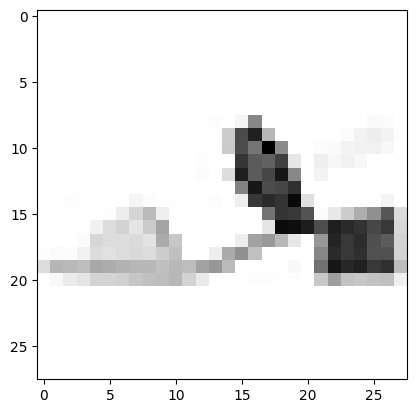

In [23]:
import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[230]
plt.imshow(1-img[0],cmap='gray')
print(f"Label:{label}")
img.shape

In [33]:
model.eval()
model.to(device)
img=img.to(device)
print(img.unsqueeze(0).shape)
with torch.no_grad():

 
   result,x_min,x_max,x_true=model.abstract_forward(img.unsqueeze(0),add_symbol=True,device=device,index=index,alpha=alpha)
print(f"result.shape = {result.shape}")
print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")

torch.Size([1, 1, 28, 28])
x.shape = torch.Size([1, 32, 12, 12])
input.shape: torch.Size([1, 32, 12, 12])
x.shape: torch.Size([1, 64])
output.shape: torch.Size([294914, 64])
torch.Size([320, 10])
torch.Size([2, 10])
NN passed 295239
result.shape = torch.Size([295239, 10])
y_min       =  tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 17.9075,  0.0000, -2.0330,
        -1.0880,  0.0000])
y_max       =  tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 27.8571,  0.0000,  4.3673,
         1.3026,  0.0000])
center Ztp  =  tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 22.8823,  0.0000,  1.1672,
         0.1073,  0.0000])
y_true      =  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 22.8751,  0.0000,  0.3150,
          0.0000,  0.0000]])
y_max-x_min =  tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 9.9496, 0.0000, 6.4003, 2.3906,
        0.0000])
Trash symbol=  tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0165, 0.5440,
        0.0000])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


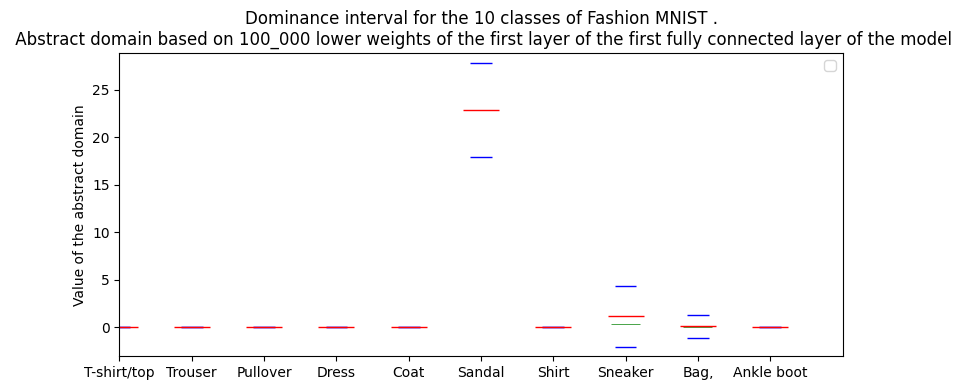

In [34]:

y_min       =  np.array(x_min)
y_max       =  np.array(x_max)
center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
y_true      =  np.expand_dims(np.array(x_true[:])[0],axis =1)
y_max_minus_y_min =  np.array(x_max-x_min)
Trash_symbol=  np.array(result[-1])


import matplotlib.pyplot as plt
import numpy as np




x = np.arange(len(y_min))
D =np.stack((y_min,y_max),axis=1)

print(D.shape)
print(center_Ztp.shape)
print(y_true.shape)
# plot:

fig,ax = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
ax.eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
ax.eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
ax.eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

ax.set(xlim=(0, 10),xticks=x,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
       ylim=(np.min(y_min)-1, np.max(y_max)+1))
plt.ylabel("Value of the abstract domain")
plt.title("Dominance interval for the 10 classes of Fashion MNIST .\n Abstract domain based on 100_000 lower weights of the first layer of the first fully connected layer of the model")
plt.legend()
plt.show()

Voici le premier affichage de relevance sur l'image d'une couche calculé par AbstractTorch

mat.shape = torch.Size([64, 4608])
result[1:294912,value]= torch.Size([294911])
map_2.shape = torch.Size([64, 4608])


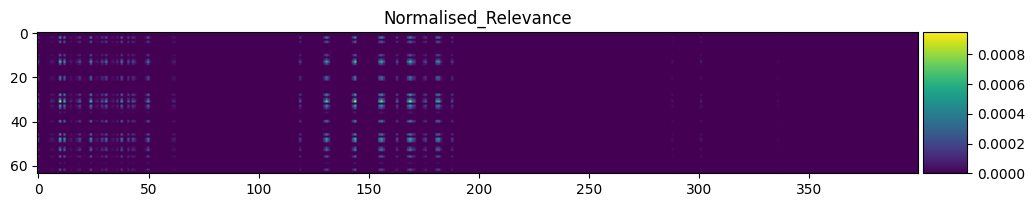

In [35]:
print(f"mat.shape = {mat.shape}")
map_relevance = torch.zeros_like(mat).flatten()
map_original = torch.zeros_like(mat).flatten() 

value=torch.argmax(result[0])
print(f"result[1:{rel_size},value]= {result[1:rel_size,value].shape}")
map_relevance[index.indices]= result[1:rel_size+1,value]
map_original[index.indices]= mat.flatten()[index.indices]
map_relevance = map_relevance.reshape(mat.shape)
map_original = map_original.reshape(mat.shape)
print(f"map_2.shape = {map_relevance.shape}")

map_normalized_relevance = torch.abs(map_relevance)#/torch.abs(map_original)
map_normalized_relevance = torch.where(torch.isnan(map_normalized_relevance), torch.zeros_like(map_normalized_relevance), map_normalized_relevance)



from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(12, 6)) 

im = plt.imshow(torch.abs(map_normalized_relevance.cpu())[:, 200:600].numpy(), cmap='viridis')

plt.title('Normalised_Relevance')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)  


plt.colorbar(im, cax=cax)

plt.show()

In [27]:
import torch
test = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
print(test.shape)
indice = (test[0]==1)
indice_2 = (test[0]==2)
print(indice)
print(test[:,indice])


torch.Size([3, 3])
tensor([ True, False, False])
tensor([[1],
        [4],
        [7]])


In [28]:
test[:,indice] = test[:,indice]*3

In [29]:
print(test)

tensor([[ 3,  2,  3],
        [12,  5,  6],
        [21,  8,  9]])
